In [1]:
import torchtext
import torch
import pandas as pd

import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn.functional as F
from torchtext import data
from torch import nn
import random

import spacy
import math

import sys
sys.path.append('..')

from utils.load_data import GLOVE_PATH, LABEL_TO_INT

In [2]:
LABEL_TO_INT

{'contradiction': 1, 'entailment': 2, 'neutral': 3}

### Load Dataset

In [3]:
source = data.Field(
        tokenize = 'spacy'
        , lower = True
        , batch_first = True
)

target = data.Field(
        sequential=False
        , use_vocab = False
        , is_target=True
)

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = '/home/ndg/users/jkurre/mnli/utils'
    , train = 'train.csv'
    , validation = 'val.csv'
    , test = 'test.csv'
    , format = 'csv'
    , fields = {'sentence': ('text', source), 'gold_label': ('target', target)}
)

source.build_vocab(train_data, min_freq=2)
source.vocab.load_vectors(torchtext.vocab.Vectors(GLOVE_PATH, cache="."))

print(source.vocab.vectors.shape)
print(f"Unique tokens in text vocabulary: {len(source.vocab)}")

torch.Size([74760, 50])
Unique tokens in text vocabulary: 74760


### Build Model

In [4]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 4, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.reshape((1, hidden.shape[1], hidden.shape[2] * 2))
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        catted = torch.cat([hidden, encoder_outputs], 2)
        energy = F.relu(self.attn(catted))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]
    
class Seq2One(nn.Module):
    def __init__(self, input_size, output_size, embed_size,
                 hidden_size, n_layers, dropout):
        
        super(Seq2One, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.dropout = nn.Dropout(dropout)
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers, dropout=dropout, 
                            bidirectional=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(self.hidden_size * 2, output_size)
        
    def forward(self, x):
        # x: (seq_length, N) where N is the batch size
        embedded = self.dropout(self.embed(x.transpose(0,1)))
        # embedded: (seq_length, N, embed_size)
        outputs, (hidden, cell) = self.lstm(embedded)
        
        weights = self.attention(hidden[-2:], outputs)
        
        context = weights.bmm(outputs.transpose(0, 1))
        context = context.transpose(0, 1)
        
        context = context.squeeze(0)
        output = self.fc(context)
        output = F.log_softmax(output, dim=1)
        
        return output

In [5]:
"""Hyperparameters"""
# training
num_epochs = 20
learning_rate = 0.001
batch_size = 64

# model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(source.vocab)
output_size = len(LABEL_TO_INT)
embed_size = 50
hidden_size = 1024 # 2014 benchmark; slightly small
num_layers = 2 # benchmark did 4
dropout = 0.5

# define iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = batch_size,
     sort_within_batch = True,
     sort_key = lambda x: len(x.text), # minimize padding
     device = device)


model = Seq2One(input_size, output_size, embed_size, hidden_size,
                  num_layers, dropout).to(device)

pad_idx = source.vocab.stoi["<pad"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# simple cross entropy cost (might be numerically unstable if pred has 0)
# https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/6
def xentropy_cost(x_target, log_x_pred):
    """Cross Entropy for One Hot Encoded Targets"""
    assert x_target.size() == log_x_pred.size(), "size fail ! " + str(x_target.size()) + " " + str(log_x_pred.size())
    return -torch.sum(x_target * log_x_pred)

In [6]:
loss_values = []
running_loss = 0.0

for epoch in range(num_epochs):
    
    print(f"Epoch {epoch} of {num_epochs}")
    
    for batch_idx, batch in enumerate(train_iterator):
        input_data = batch.text.to(device)
        target_data = batch.target.to(device)
        target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))
        
        output = model(input_data)
        
        optimizer.zero_grad()
        loss = xentropy_cost(target_data_one_hot, output)
        
        if batch_idx % 10 == 9:
            print("XEntropy Loss:", round(loss.item(),2))
        
        # address gradient issue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        running_loss =+ loss.item() * batch_size
    
    loss_values.append(running_loss)

Epoch 0 of 20
XEntropy Loss: 70.65
XEntropy Loss: 70.96
XEntropy Loss: 70.63
XEntropy Loss: 71.16
XEntropy Loss: 69.28
XEntropy Loss: 70.46
XEntropy Loss: 70.36
XEntropy Loss: 72.56
XEntropy Loss: 74.05
XEntropy Loss: 70.72
XEntropy Loss: 68.84
XEntropy Loss: 70.37
XEntropy Loss: 70.3
XEntropy Loss: 70.1
XEntropy Loss: 70.09
XEntropy Loss: 70.74
XEntropy Loss: 70.04
XEntropy Loss: 71.04
XEntropy Loss: 70.66
XEntropy Loss: 70.07
XEntropy Loss: 68.97
XEntropy Loss: 70.42
XEntropy Loss: 70.44
XEntropy Loss: 70.87
XEntropy Loss: 70.55
XEntropy Loss: 71.09
XEntropy Loss: 70.2
XEntropy Loss: 70.21
XEntropy Loss: 70.87
XEntropy Loss: 70.67
XEntropy Loss: 71.09
XEntropy Loss: 70.22
XEntropy Loss: 70.31
XEntropy Loss: 68.6
XEntropy Loss: 70.34
XEntropy Loss: 70.41
XEntropy Loss: 70.39
XEntropy Loss: 70.38
XEntropy Loss: 70.3
XEntropy Loss: 70.3
XEntropy Loss: 70.31
XEntropy Loss: 70.32
XEntropy Loss: 70.28
XEntropy Loss: 69.29
XEntropy Loss: 70.23
XEntropy Loss: 69.22
XEntropy Loss: 68.88
XEntr

XEntropy Loss: 70.64
XEntropy Loss: 70.3
XEntropy Loss: 69.32
XEntropy Loss: 70.52
XEntropy Loss: 70.47
XEntropy Loss: 70.87
XEntropy Loss: 69.23
XEntropy Loss: 69.82
XEntropy Loss: 71.63
XEntropy Loss: 70.17
XEntropy Loss: 70.25
XEntropy Loss: 70.7
XEntropy Loss: 69.36
XEntropy Loss: 70.44
XEntropy Loss: 70.48
XEntropy Loss: 70.51
XEntropy Loss: 67.35
XEntropy Loss: 70.83
XEntropy Loss: 70.76
XEntropy Loss: 69.67
XEntropy Loss: 68.24
XEntropy Loss: 70.38
XEntropy Loss: 71.26
XEntropy Loss: 70.57
XEntropy Loss: 70.99
XEntropy Loss: 71.19
XEntropy Loss: 70.28
XEntropy Loss: 71.33
XEntropy Loss: 69.93
XEntropy Loss: 70.05
XEntropy Loss: 70.08
XEntropy Loss: 70.62
XEntropy Loss: 70.47
XEntropy Loss: 69.86
XEntropy Loss: 70.24
XEntropy Loss: 70.71
XEntropy Loss: 70.31
XEntropy Loss: 69.8
XEntropy Loss: 72.34
XEntropy Loss: 68.93
XEntropy Loss: 71.3
XEntropy Loss: 70.1
XEntropy Loss: 70.7
XEntropy Loss: 70.36
XEntropy Loss: 70.22
XEntropy Loss: 70.33
XEntropy Loss: 70.35
XEntropy Loss: 70.7

XEntropy Loss: 68.81
XEntropy Loss: 66.25
XEntropy Loss: 73.53
XEntropy Loss: 64.43
XEntropy Loss: 67.12
XEntropy Loss: 70.88
XEntropy Loss: 65.32
XEntropy Loss: 66.69
XEntropy Loss: 64.04
XEntropy Loss: 62.22
XEntropy Loss: 68.96
XEntropy Loss: 65.39
XEntropy Loss: 65.9
XEntropy Loss: 69.52
XEntropy Loss: 66.15
XEntropy Loss: 62.94
XEntropy Loss: 69.2
XEntropy Loss: 70.64
XEntropy Loss: 66.58
XEntropy Loss: 67.35
XEntropy Loss: 63.66
XEntropy Loss: 70.54
XEntropy Loss: 62.27
XEntropy Loss: 68.82
XEntropy Loss: 64.28
XEntropy Loss: 64.77
XEntropy Loss: 65.68
XEntropy Loss: 67.5
XEntropy Loss: 72.64
XEntropy Loss: 64.2
XEntropy Loss: 64.7
XEntropy Loss: 73.85
XEntropy Loss: 68.04
XEntropy Loss: 65.9
XEntropy Loss: 61.02
XEntropy Loss: 67.72
XEntropy Loss: 66.44
XEntropy Loss: 71.92
XEntropy Loss: 63.26
XEntropy Loss: 67.19
XEntropy Loss: 59.08
XEntropy Loss: 68.11
XEntropy Loss: 62.02
XEntropy Loss: 69.22
XEntropy Loss: 67.98
XEntropy Loss: 65.37
XEntropy Loss: 62.96
XEntropy Loss: 69.4

XEntropy Loss: 70.63
XEntropy Loss: 68.46
XEntropy Loss: 67.63
XEntropy Loss: 61.07
XEntropy Loss: 66.87
XEntropy Loss: 57.92
XEntropy Loss: 64.68
XEntropy Loss: 65.09
XEntropy Loss: 63.15
XEntropy Loss: 66.95
XEntropy Loss: 63.9
XEntropy Loss: 63.42
XEntropy Loss: 53.61
XEntropy Loss: 65.27
XEntropy Loss: 62.04
XEntropy Loss: 61.27
XEntropy Loss: 71.1
XEntropy Loss: 72.39
XEntropy Loss: 58.39
XEntropy Loss: 57.83
XEntropy Loss: 66.27
XEntropy Loss: 64.97
XEntropy Loss: 65.92
XEntropy Loss: 67.84
XEntropy Loss: 67.74
XEntropy Loss: 61.47
XEntropy Loss: 68.73
XEntropy Loss: 67.23
XEntropy Loss: 66.61
XEntropy Loss: 66.57
XEntropy Loss: 59.13
XEntropy Loss: 64.39
XEntropy Loss: 60.86
XEntropy Loss: 65.32
XEntropy Loss: 65.53
XEntropy Loss: 66.17
XEntropy Loss: 70.09
XEntropy Loss: 63.57
XEntropy Loss: 66.69
XEntropy Loss: 62.97
XEntropy Loss: 66.28
XEntropy Loss: 64.91
XEntropy Loss: 62.57
XEntropy Loss: 57.62
XEntropy Loss: 56.63
XEntropy Loss: 55.61
XEntropy Loss: 55.16
XEntropy Loss: 

XEntropy Loss: 61.67
XEntropy Loss: 59.77
XEntropy Loss: 67.79
XEntropy Loss: 58.29
XEntropy Loss: 58.41
XEntropy Loss: 61.35
XEntropy Loss: 57.38
XEntropy Loss: 61.9
XEntropy Loss: 64.41
XEntropy Loss: 64.08
XEntropy Loss: 55.2
XEntropy Loss: 58.14
XEntropy Loss: 65.69
XEntropy Loss: 61.61
XEntropy Loss: 63.83
XEntropy Loss: 67.53
XEntropy Loss: 58.49
XEntropy Loss: 56.77
XEntropy Loss: 61.93
XEntropy Loss: 70.98
XEntropy Loss: 57.6
XEntropy Loss: 63.47
XEntropy Loss: 60.58
XEntropy Loss: 59.68
XEntropy Loss: 60.11
XEntropy Loss: 53.7
XEntropy Loss: 61.79
XEntropy Loss: 55.74
XEntropy Loss: 62.38
XEntropy Loss: 55.92
XEntropy Loss: 56.85
XEntropy Loss: 59.68
XEntropy Loss: 56.48
XEntropy Loss: 62.52
XEntropy Loss: 57.23
XEntropy Loss: 60.63
XEntropy Loss: 60.06
XEntropy Loss: 65.99
XEntropy Loss: 63.52
XEntropy Loss: 61.38
XEntropy Loss: 60.66
XEntropy Loss: 55.75
XEntropy Loss: 59.65
XEntropy Loss: 59.76
XEntropy Loss: 61.63
XEntropy Loss: 64.57
XEntropy Loss: 66.77
XEntropy Loss: 59

XEntropy Loss: 62.54
XEntropy Loss: 60.97
XEntropy Loss: 63.04
XEntropy Loss: 60.0
XEntropy Loss: 57.54
XEntropy Loss: 55.99
XEntropy Loss: 62.96
XEntropy Loss: 53.44
XEntropy Loss: 66.15
XEntropy Loss: 60.03
XEntropy Loss: 53.85
XEntropy Loss: 60.26
XEntropy Loss: 51.38
XEntropy Loss: 59.71
XEntropy Loss: 65.84
XEntropy Loss: 64.42
XEntropy Loss: 54.55
XEntropy Loss: 65.8
XEntropy Loss: 63.82
XEntropy Loss: 61.16
XEntropy Loss: 65.87
XEntropy Loss: 50.77
XEntropy Loss: 56.73
XEntropy Loss: 61.99
XEntropy Loss: 62.08
XEntropy Loss: 58.83
XEntropy Loss: 58.23
XEntropy Loss: 59.06
XEntropy Loss: 59.6
XEntropy Loss: 67.78
XEntropy Loss: 66.21
XEntropy Loss: 54.85
XEntropy Loss: 61.85
XEntropy Loss: 54.04
XEntropy Loss: 50.98
XEntropy Loss: 50.82
XEntropy Loss: 61.65
XEntropy Loss: 52.79
XEntropy Loss: 57.65
XEntropy Loss: 61.58
XEntropy Loss: 54.94
XEntropy Loss: 64.75
XEntropy Loss: 63.55
XEntropy Loss: 62.43
XEntropy Loss: 58.66
XEntropy Loss: 66.36
XEntropy Loss: 63.52
XEntropy Loss: 6

XEntropy Loss: 69.72
XEntropy Loss: 57.96
XEntropy Loss: 57.3
XEntropy Loss: 61.96
XEntropy Loss: 60.43
XEntropy Loss: 61.58
XEntropy Loss: 58.63
XEntropy Loss: 67.69
XEntropy Loss: 49.24
XEntropy Loss: 59.77
XEntropy Loss: 61.65
XEntropy Loss: 63.74
XEntropy Loss: 54.39
XEntropy Loss: 50.69
XEntropy Loss: 65.33
XEntropy Loss: 67.01
XEntropy Loss: 60.31
XEntropy Loss: 47.64
XEntropy Loss: 65.6
XEntropy Loss: 56.55
XEntropy Loss: 56.06
XEntropy Loss: 56.2
XEntropy Loss: 63.03
XEntropy Loss: 57.22
XEntropy Loss: 65.89
XEntropy Loss: 60.77
XEntropy Loss: 63.35
XEntropy Loss: 61.54
XEntropy Loss: 54.91
XEntropy Loss: 53.05
XEntropy Loss: 52.18
XEntropy Loss: 56.63
XEntropy Loss: 57.74
XEntropy Loss: 45.9
XEntropy Loss: 66.19
XEntropy Loss: 53.12
XEntropy Loss: 55.82
XEntropy Loss: 59.57
XEntropy Loss: 57.47
XEntropy Loss: 59.81
XEntropy Loss: 60.23
XEntropy Loss: 48.4
XEntropy Loss: 58.58
XEntropy Loss: 60.59
XEntropy Loss: 49.32
XEntropy Loss: 53.68
XEntropy Loss: 61.62
XEntropy Loss: 66.

XEntropy Loss: 55.16
XEntropy Loss: 57.66
XEntropy Loss: 62.88
XEntropy Loss: 64.11
XEntropy Loss: 68.25
XEntropy Loss: 61.41
XEntropy Loss: 61.47
XEntropy Loss: 51.95
XEntropy Loss: 67.85
XEntropy Loss: 64.44
XEntropy Loss: 63.75
XEntropy Loss: 53.48
XEntropy Loss: 63.92
XEntropy Loss: 57.82
XEntropy Loss: 59.57
XEntropy Loss: 61.54
XEntropy Loss: 62.86
XEntropy Loss: 53.85
XEntropy Loss: 56.73
XEntropy Loss: 61.98
XEntropy Loss: 59.11
XEntropy Loss: 51.76
XEntropy Loss: 56.59
XEntropy Loss: 57.78
XEntropy Loss: 58.97
XEntropy Loss: 64.81
XEntropy Loss: 57.74
XEntropy Loss: 60.99
XEntropy Loss: 64.51
XEntropy Loss: 51.43
XEntropy Loss: 60.03
XEntropy Loss: 58.55
XEntropy Loss: 59.6
XEntropy Loss: 65.75
XEntropy Loss: 56.12
XEntropy Loss: 52.08
XEntropy Loss: 64.37
XEntropy Loss: 64.42
XEntropy Loss: 61.85
XEntropy Loss: 65.03
XEntropy Loss: 54.99
XEntropy Loss: 58.26
XEntropy Loss: 58.17
XEntropy Loss: 55.61
XEntropy Loss: 59.33
XEntropy Loss: 62.26
XEntropy Loss: 62.36
XEntropy Loss:

XEntropy Loss: 61.89
XEntropy Loss: 60.22
XEntropy Loss: 52.42
XEntropy Loss: 62.56
XEntropy Loss: 55.56
XEntropy Loss: 62.8
XEntropy Loss: 60.64
XEntropy Loss: 51.99
XEntropy Loss: 47.91
XEntropy Loss: 54.39
XEntropy Loss: 60.7
XEntropy Loss: 63.28
XEntropy Loss: 55.74
XEntropy Loss: 60.04
XEntropy Loss: 73.52
XEntropy Loss: 65.09
XEntropy Loss: 52.73
XEntropy Loss: 58.81
XEntropy Loss: 55.33
XEntropy Loss: 58.22
XEntropy Loss: 57.95
XEntropy Loss: 56.11
XEntropy Loss: 57.68
XEntropy Loss: 60.42
XEntropy Loss: 57.69
XEntropy Loss: 56.62
XEntropy Loss: 60.21
XEntropy Loss: 56.37
XEntropy Loss: 68.28
XEntropy Loss: 64.39
XEntropy Loss: 57.38
XEntropy Loss: 55.16
XEntropy Loss: 58.62
XEntropy Loss: 61.23
XEntropy Loss: 55.6
XEntropy Loss: 49.46
XEntropy Loss: 54.46
XEntropy Loss: 61.32
XEntropy Loss: 56.1
XEntropy Loss: 63.18
XEntropy Loss: 58.6
XEntropy Loss: 56.9
XEntropy Loss: 56.13
XEntropy Loss: 61.69
XEntropy Loss: 57.34
XEntropy Loss: 66.07
XEntropy Loss: 64.73
XEntropy Loss: 62.9

XEntropy Loss: 49.84
XEntropy Loss: 60.96
XEntropy Loss: 52.62
XEntropy Loss: 56.31
XEntropy Loss: 69.68
XEntropy Loss: 67.33
XEntropy Loss: 55.29
XEntropy Loss: 58.77
XEntropy Loss: 53.08
XEntropy Loss: 53.31
XEntropy Loss: 47.74
XEntropy Loss: 60.22
XEntropy Loss: 54.8
XEntropy Loss: 59.4
XEntropy Loss: 52.22
XEntropy Loss: 56.04
XEntropy Loss: 47.25
XEntropy Loss: 53.43
XEntropy Loss: 58.59
XEntropy Loss: 60.43
XEntropy Loss: 69.15
XEntropy Loss: 55.47
XEntropy Loss: 54.0
XEntropy Loss: 56.81
XEntropy Loss: 66.26
XEntropy Loss: 63.93
XEntropy Loss: 61.0
XEntropy Loss: 54.64
XEntropy Loss: 53.7
XEntropy Loss: 56.51
XEntropy Loss: 52.04
XEntropy Loss: 56.75
XEntropy Loss: 56.28
XEntropy Loss: 49.29
XEntropy Loss: 54.73
XEntropy Loss: 46.09
XEntropy Loss: 51.72
XEntropy Loss: 60.65
XEntropy Loss: 59.46
XEntropy Loss: 56.8
XEntropy Loss: 55.62
XEntropy Loss: 55.37
XEntropy Loss: 52.47
XEntropy Loss: 65.04
XEntropy Loss: 56.87
XEntropy Loss: 63.7
XEntropy Loss: 67.14
XEntropy Loss: 57.39

XEntropy Loss: 57.48
XEntropy Loss: 48.86
XEntropy Loss: 50.6
XEntropy Loss: 49.4
XEntropy Loss: 54.96
XEntropy Loss: 54.84
XEntropy Loss: 59.01
XEntropy Loss: 55.99
XEntropy Loss: 56.71
XEntropy Loss: 53.14
XEntropy Loss: 54.87
XEntropy Loss: 52.39
XEntropy Loss: 51.46
XEntropy Loss: 61.32
XEntropy Loss: 51.81
XEntropy Loss: 50.08
XEntropy Loss: 61.27
XEntropy Loss: 58.35
XEntropy Loss: 62.53
XEntropy Loss: 59.3
XEntropy Loss: 58.48
XEntropy Loss: 55.92
XEntropy Loss: 57.85
XEntropy Loss: 51.17
XEntropy Loss: 61.68
XEntropy Loss: 54.29
XEntropy Loss: 54.76
XEntropy Loss: 50.48
XEntropy Loss: 62.59
XEntropy Loss: 56.14
XEntropy Loss: 56.67
XEntropy Loss: 49.36
XEntropy Loss: 61.78
XEntropy Loss: 46.98
XEntropy Loss: 53.79
XEntropy Loss: 49.26
XEntropy Loss: 47.68
XEntropy Loss: 51.92
XEntropy Loss: 54.41
XEntropy Loss: 55.59
XEntropy Loss: 49.04
XEntropy Loss: 52.23
XEntropy Loss: 56.0
XEntropy Loss: 56.74
XEntropy Loss: 60.29
XEntropy Loss: 54.37
XEntropy Loss: 58.8
XEntropy Loss: 60.

XEntropy Loss: 58.84
XEntropy Loss: 56.97
XEntropy Loss: 47.95
XEntropy Loss: 52.99
XEntropy Loss: 52.16
XEntropy Loss: 53.04
XEntropy Loss: 52.78
XEntropy Loss: 60.05
XEntropy Loss: 58.02
XEntropy Loss: 55.52
XEntropy Loss: 64.26
XEntropy Loss: 48.93
XEntropy Loss: 51.9
XEntropy Loss: 62.9
XEntropy Loss: 62.1
XEntropy Loss: 61.49
XEntropy Loss: 53.78
XEntropy Loss: 58.98
XEntropy Loss: 48.12
XEntropy Loss: 54.97
XEntropy Loss: 55.2
XEntropy Loss: 54.54
XEntropy Loss: 56.29
XEntropy Loss: 53.8
XEntropy Loss: 53.92
XEntropy Loss: 56.68
XEntropy Loss: 55.94
XEntropy Loss: 47.9
XEntropy Loss: 60.18
XEntropy Loss: 59.68
XEntropy Loss: 55.4
XEntropy Loss: 51.14
XEntropy Loss: 64.33
XEntropy Loss: 50.1
XEntropy Loss: 58.5
XEntropy Loss: 66.12
XEntropy Loss: 55.77
XEntropy Loss: 54.01
XEntropy Loss: 49.08
XEntropy Loss: 59.8
XEntropy Loss: 53.47
XEntropy Loss: 59.84
XEntropy Loss: 49.41
XEntropy Loss: 54.28
XEntropy Loss: 59.25
XEntropy Loss: 55.45
XEntropy Loss: 59.06
XEntropy Loss: 58.31
XE

XEntropy Loss: 49.9
XEntropy Loss: 52.31
XEntropy Loss: 58.21
XEntropy Loss: 58.09
XEntropy Loss: 53.51
XEntropy Loss: 53.54
XEntropy Loss: 56.49
XEntropy Loss: 54.3
XEntropy Loss: 52.59
XEntropy Loss: 57.86
XEntropy Loss: 46.27
XEntropy Loss: 56.37
XEntropy Loss: 53.31
XEntropy Loss: 51.56
XEntropy Loss: 52.13
XEntropy Loss: 44.72
XEntropy Loss: 58.39
XEntropy Loss: 59.7
XEntropy Loss: 60.1
XEntropy Loss: 54.13
XEntropy Loss: 55.52
XEntropy Loss: 50.93
XEntropy Loss: 65.49
XEntropy Loss: 55.02
XEntropy Loss: 48.42
XEntropy Loss: 63.32
XEntropy Loss: 51.72
XEntropy Loss: 54.41
XEntropy Loss: 51.42
XEntropy Loss: 55.65
XEntropy Loss: 44.36
XEntropy Loss: 54.2
XEntropy Loss: 54.55
XEntropy Loss: 61.97
XEntropy Loss: 56.31
XEntropy Loss: 54.04
XEntropy Loss: 55.0
XEntropy Loss: 55.98
XEntropy Loss: 59.97
XEntropy Loss: 58.6
XEntropy Loss: 50.51
XEntropy Loss: 59.71
XEntropy Loss: 53.69
XEntropy Loss: 51.19
XEntropy Loss: 59.7
XEntropy Loss: 60.33
XEntropy Loss: 55.57
XEntropy Loss: 44.43


XEntropy Loss: 48.52
XEntropy Loss: 47.93
XEntropy Loss: 50.93
XEntropy Loss: 49.16
XEntropy Loss: 58.09
XEntropy Loss: 50.34
XEntropy Loss: 57.49
XEntropy Loss: 60.72
XEntropy Loss: 45.32
XEntropy Loss: 53.99
XEntropy Loss: 53.91
XEntropy Loss: 58.42
XEntropy Loss: 60.68
XEntropy Loss: 60.75
XEntropy Loss: 52.36
XEntropy Loss: 56.58
XEntropy Loss: 53.45
XEntropy Loss: 56.23
XEntropy Loss: 51.74
XEntropy Loss: 54.7
XEntropy Loss: 56.24
XEntropy Loss: 56.49
XEntropy Loss: 55.47
XEntropy Loss: 56.66
XEntropy Loss: 46.82
XEntropy Loss: 44.13
XEntropy Loss: 52.49
XEntropy Loss: 52.34
XEntropy Loss: 59.45
XEntropy Loss: 63.87
XEntropy Loss: 49.59
XEntropy Loss: 56.98
XEntropy Loss: 50.02
XEntropy Loss: 49.95
XEntropy Loss: 53.82
XEntropy Loss: 61.3
XEntropy Loss: 48.37
XEntropy Loss: 65.05
XEntropy Loss: 56.22
XEntropy Loss: 52.28
XEntropy Loss: 58.82
XEntropy Loss: 49.51
XEntropy Loss: 53.94
XEntropy Loss: 48.38
XEntropy Loss: 58.59
XEntropy Loss: 44.25
XEntropy Loss: 53.13
XEntropy Loss: 

XEntropy Loss: 45.27
XEntropy Loss: 50.8
XEntropy Loss: 53.02
XEntropy Loss: 61.16
XEntropy Loss: 59.03
XEntropy Loss: 56.28
XEntropy Loss: 62.58
XEntropy Loss: 56.37
XEntropy Loss: 57.19
XEntropy Loss: 63.04
XEntropy Loss: 48.73
XEntropy Loss: 49.22
XEntropy Loss: 50.26
XEntropy Loss: 52.44
XEntropy Loss: 49.66
XEntropy Loss: 54.3
XEntropy Loss: 51.9
XEntropy Loss: 57.64
XEntropy Loss: 47.34
XEntropy Loss: 62.98
XEntropy Loss: 49.8
XEntropy Loss: 52.71
XEntropy Loss: 58.4
XEntropy Loss: 48.8
XEntropy Loss: 65.65
XEntropy Loss: 53.22
XEntropy Loss: 60.47
XEntropy Loss: 48.05
XEntropy Loss: 48.82
XEntropy Loss: 54.79
XEntropy Loss: 60.32
XEntropy Loss: 45.73
Epoch 15 of 20
XEntropy Loss: 42.41
XEntropy Loss: 55.13
XEntropy Loss: 63.9
XEntropy Loss: 55.31
XEntropy Loss: 54.94
XEntropy Loss: 50.08
XEntropy Loss: 49.16
XEntropy Loss: 48.9
XEntropy Loss: 43.69
XEntropy Loss: 55.24
XEntropy Loss: 55.1
XEntropy Loss: 46.03
XEntropy Loss: 57.55
XEntropy Loss: 50.3
XEntropy Loss: 46.26
XEntropy

XEntropy Loss: 50.94
XEntropy Loss: 54.09
XEntropy Loss: 59.12
XEntropy Loss: 46.81
XEntropy Loss: 66.58
XEntropy Loss: 48.68
XEntropy Loss: 48.68
XEntropy Loss: 49.17
Epoch 16 of 20
XEntropy Loss: 49.34
XEntropy Loss: 51.38
XEntropy Loss: 55.69
XEntropy Loss: 50.66
XEntropy Loss: 58.62
XEntropy Loss: 52.27
XEntropy Loss: 57.2
XEntropy Loss: 57.2
XEntropy Loss: 53.29
XEntropy Loss: 59.22
XEntropy Loss: 54.57
XEntropy Loss: 48.61
XEntropy Loss: 46.82
XEntropy Loss: 43.25
XEntropy Loss: 50.4
XEntropy Loss: 52.33
XEntropy Loss: 49.16
XEntropy Loss: 50.85
XEntropy Loss: 50.22
XEntropy Loss: 49.04
XEntropy Loss: 49.65
XEntropy Loss: 61.06
XEntropy Loss: 51.95
XEntropy Loss: 55.46
XEntropy Loss: 58.42
XEntropy Loss: 41.16
XEntropy Loss: 49.98
XEntropy Loss: 69.08
XEntropy Loss: 46.66
XEntropy Loss: 58.32
XEntropy Loss: 64.59
XEntropy Loss: 50.52
XEntropy Loss: 45.77
XEntropy Loss: 48.04
XEntropy Loss: 41.14
XEntropy Loss: 42.61
XEntropy Loss: 53.16
XEntropy Loss: 51.77
XEntropy Loss: 54.74
X

XEntropy Loss: 54.5
XEntropy Loss: 57.71
XEntropy Loss: 54.32
XEntropy Loss: 43.15
XEntropy Loss: 54.65
XEntropy Loss: 44.96
XEntropy Loss: 53.81
XEntropy Loss: 54.45
XEntropy Loss: 47.87
XEntropy Loss: 52.62
XEntropy Loss: 53.88
XEntropy Loss: 71.86
XEntropy Loss: 53.35
XEntropy Loss: 56.79
XEntropy Loss: 53.05
XEntropy Loss: 50.66
XEntropy Loss: 54.44
XEntropy Loss: 43.66
XEntropy Loss: 54.75
XEntropy Loss: 45.41
XEntropy Loss: 57.0
XEntropy Loss: 63.61
XEntropy Loss: 58.64
XEntropy Loss: 44.48
XEntropy Loss: 46.19
XEntropy Loss: 53.62
XEntropy Loss: 48.3
XEntropy Loss: 62.72
XEntropy Loss: 60.26
XEntropy Loss: 52.79
XEntropy Loss: 45.46
XEntropy Loss: 56.54
XEntropy Loss: 58.21
XEntropy Loss: 58.39
XEntropy Loss: 46.51
XEntropy Loss: 47.82
XEntropy Loss: 47.17
XEntropy Loss: 58.92
XEntropy Loss: 52.05
XEntropy Loss: 50.25
XEntropy Loss: 56.35
XEntropy Loss: 47.89
XEntropy Loss: 61.76
XEntropy Loss: 54.64
XEntropy Loss: 45.81
XEntropy Loss: 49.06
XEntropy Loss: 54.35
XEntropy Loss: 4

XEntropy Loss: 46.41
XEntropy Loss: 46.63
XEntropy Loss: 56.26
XEntropy Loss: 61.0
XEntropy Loss: 47.23
XEntropy Loss: 57.23
XEntropy Loss: 49.53
XEntropy Loss: 45.51
XEntropy Loss: 47.25
XEntropy Loss: 51.51
XEntropy Loss: 48.42
XEntropy Loss: 47.91
XEntropy Loss: 49.01
XEntropy Loss: 47.84
XEntropy Loss: 56.29
XEntropy Loss: 54.83
XEntropy Loss: 42.28
XEntropy Loss: 47.22
XEntropy Loss: 49.01
XEntropy Loss: 47.71
XEntropy Loss: 55.61
XEntropy Loss: 41.06
XEntropy Loss: 63.24
XEntropy Loss: 52.52
XEntropy Loss: 61.74
XEntropy Loss: 52.09
XEntropy Loss: 47.11
XEntropy Loss: 53.78
XEntropy Loss: 63.0
XEntropy Loss: 54.67
XEntropy Loss: 49.16
XEntropy Loss: 43.25
XEntropy Loss: 41.07
XEntropy Loss: 50.05
XEntropy Loss: 57.95
XEntropy Loss: 46.08
XEntropy Loss: 75.72
XEntropy Loss: 51.96
XEntropy Loss: 51.57
XEntropy Loss: 50.05
XEntropy Loss: 56.43
XEntropy Loss: 48.77
XEntropy Loss: 59.91
XEntropy Loss: 51.94
XEntropy Loss: 57.89
XEntropy Loss: 55.95
XEntropy Loss: 50.31
XEntropy Loss: 

XEntropy Loss: 48.98
XEntropy Loss: 50.25
XEntropy Loss: 52.01
XEntropy Loss: 49.41
XEntropy Loss: 48.65
XEntropy Loss: 58.22
XEntropy Loss: 43.54
XEntropy Loss: 53.3
XEntropy Loss: 44.47
XEntropy Loss: 45.09
XEntropy Loss: 49.64
XEntropy Loss: 51.37
XEntropy Loss: 48.29
XEntropy Loss: 41.8
XEntropy Loss: 46.32
XEntropy Loss: 47.59
XEntropy Loss: 50.22
XEntropy Loss: 53.55
XEntropy Loss: 51.6
XEntropy Loss: 52.46
XEntropy Loss: 51.39
XEntropy Loss: 42.16
XEntropy Loss: 45.55
XEntropy Loss: 46.6
XEntropy Loss: 47.26
XEntropy Loss: 49.29
XEntropy Loss: 58.62
XEntropy Loss: 46.58
XEntropy Loss: 49.34
XEntropy Loss: 44.77
XEntropy Loss: 43.59
XEntropy Loss: 49.44
XEntropy Loss: 54.7
XEntropy Loss: 44.06
XEntropy Loss: 49.82
XEntropy Loss: 57.31
XEntropy Loss: 61.4
XEntropy Loss: 56.88
XEntropy Loss: 56.03
XEntropy Loss: 47.17
XEntropy Loss: 55.09
XEntropy Loss: 50.42
XEntropy Loss: 43.24
XEntropy Loss: 50.65
XEntropy Loss: 54.22
XEntropy Loss: 49.24
XEntropy Loss: 45.7
XEntropy Loss: 50.42

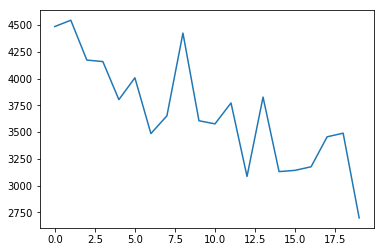

In [7]:
plt.plot(loss_values)
plt.show()

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("---")
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
PATH = '/home/ndg/users/jkurre/mnli/models/bilstm.pt'
torch.save(model, PATH)

Model's state_dict:
embed.weight 	 torch.Size([74760, 50])
lstm.weight_ih_l0 	 torch.Size([4096, 50])
lstm.weight_hh_l0 	 torch.Size([4096, 1024])
lstm.bias_ih_l0 	 torch.Size([4096])
lstm.bias_hh_l0 	 torch.Size([4096])
lstm.weight_ih_l0_reverse 	 torch.Size([4096, 50])
lstm.weight_hh_l0_reverse 	 torch.Size([4096, 1024])
lstm.bias_ih_l0_reverse 	 torch.Size([4096])
lstm.bias_hh_l0_reverse 	 torch.Size([4096])
lstm.weight_ih_l1 	 torch.Size([4096, 2048])
lstm.weight_hh_l1 	 torch.Size([4096, 1024])
lstm.bias_ih_l1 	 torch.Size([4096])
lstm.bias_hh_l1 	 torch.Size([4096])
lstm.weight_ih_l1_reverse 	 torch.Size([4096, 2048])
lstm.weight_hh_l1_reverse 	 torch.Size([4096, 1024])
lstm.bias_ih_l1_reverse 	 torch.Size([4096])
lstm.bias_hh_l1_reverse 	 torch.Size([4096])
attention.v 	 torch.Size([1024])
attention.attn.weight 	 torch.Size([1024, 4096])
attention.attn.bias 	 torch.Size([1024])
fc.weight 	 torch.Size([3, 2048])
fc.bias 	 torch.Size([3])
---
Optimizer's state_dict:
state 	 {14037

/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Seq2One. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ndg/users/jkurre/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
all_acc = []

for batch_idx, batch in enumerate(test_iterator):
    input_data = batch.text.to(device)
    target_data = batch.target.to(device)
    target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))

    output = model(input_data)
    max_output = torch.max(output, 1)[1]
    predicted_labels = max_output.view(batch.target.size()).data
    n_correct = (predicted_labels == batch.target.data).sum()
    n_total = batch.batch_size
    test_acc = 100. * n_correct/n_total
    print("test accuracy - %f" % test_acc)
    all_acc.append(test_acc)

test accuracy - 20.312500
test accuracy - 15.625000
test accuracy - 20.312500
test accuracy - 17.187500
test accuracy - 15.625000
test accuracy - 18.750000
test accuracy - 15.625000
test accuracy - 20.312500
test accuracy - 15.625000
test accuracy - 23.437500
test accuracy - 21.875000
test accuracy - 18.750000
test accuracy - 20.312500
test accuracy - 23.437500
test accuracy - 7.812500
test accuracy - 23.437500
test accuracy - 17.187500
test accuracy - 12.500000
test accuracy - 20.312500
test accuracy - 17.187500
test accuracy - 23.437500
test accuracy - 12.500000
test accuracy - 9.375000
test accuracy - 10.937500
test accuracy - 18.750000
test accuracy - 21.875000
test accuracy - 20.312500
test accuracy - 6.250000
test accuracy - 15.625000
test accuracy - 12.500000
test accuracy - 14.062500
test accuracy - 18.750000
test accuracy - 6.250000
test accuracy - 15.625000
test accuracy - 7.812500
test accuracy - 18.750000
test accuracy - 18.750000
test accuracy - 15.625000
test accuracy - 1

test accuracy - 7.812500
test accuracy - 12.500000
test accuracy - 9.375000
test accuracy - 9.375000
test accuracy - 10.937500
test accuracy - 14.062500
test accuracy - 17.187500
test accuracy - 23.437500
test accuracy - 10.937500
test accuracy - 20.312500
test accuracy - 10.937500
test accuracy - 9.375000
test accuracy - 15.625000
test accuracy - 10.937500
test accuracy - 15.625000
test accuracy - 12.500000
test accuracy - 17.187500
test accuracy - 14.062500
test accuracy - 21.875000
test accuracy - 10.937500
test accuracy - 10.937500
test accuracy - 20.312500
test accuracy - 20.312500
test accuracy - 18.750000
test accuracy - 17.187500
test accuracy - 10.937500
test accuracy - 10.937500
test accuracy - 9.375000
test accuracy - 14.062500
test accuracy - 18.750000
test accuracy - 10.937500
test accuracy - 25.000000
test accuracy - 7.812500
test accuracy - 10.937500
test accuracy - 12.500000
test accuracy - 18.750000
test accuracy - 18.750000
test accuracy - 9.375000
test accuracy - 20.

test accuracy - 12.500000
test accuracy - 9.375000
test accuracy - 18.750000
test accuracy - 14.062500
test accuracy - 7.812500
test accuracy - 7.812500
test accuracy - 14.062500
test accuracy - 26.562500
test accuracy - 14.062500
test accuracy - 10.937500
test accuracy - 12.500000
test accuracy - 9.375000
test accuracy - 17.187500
test accuracy - 12.500000
test accuracy - 15.625000
test accuracy - 15.625000
test accuracy - 10.937500
test accuracy - 21.875000
test accuracy - 12.500000
test accuracy - 15.625000
test accuracy - 6.250000
test accuracy - 10.937500
test accuracy - 10.937500
test accuracy - 12.500000
test accuracy - 14.062500
test accuracy - 12.500000
test accuracy - 15.625000
test accuracy - 12.500000
test accuracy - 12.500000
test accuracy - 7.812500
test accuracy - 18.750000
test accuracy - 21.875000
test accuracy - 21.875000
test accuracy - 12.500000
test accuracy - 20.312500
test accuracy - 14.062500
test accuracy - 15.625000
test accuracy - 10.937500
test accuracy - 6.

test accuracy - 15.625000
test accuracy - 14.062500
test accuracy - 7.812500
test accuracy - 18.750000
test accuracy - 23.437500
test accuracy - 17.187500
test accuracy - 12.500000
test accuracy - 15.625000
test accuracy - 15.625000
test accuracy - 12.500000
test accuracy - 15.625000
test accuracy - 17.187500
test accuracy - 17.187500
test accuracy - 9.375000
test accuracy - 20.312500
test accuracy - 7.812500
test accuracy - 14.062500
test accuracy - 12.500000
test accuracy - 9.375000
test accuracy - 10.937500
test accuracy - 10.937500
test accuracy - 15.625000
test accuracy - 17.187500
test accuracy - 23.437500
test accuracy - 10.937500
test accuracy - 20.312500
test accuracy - 9.375000
test accuracy - 15.625000
test accuracy - 18.750000
test accuracy - 26.562500
test accuracy - 15.625000
test accuracy - 6.250000
test accuracy - 12.500000
test accuracy - 9.375000
test accuracy - 15.625000
test accuracy - 12.500000
test accuracy - 14.062500
test accuracy - 17.187500
test accuracy - 15.

In [10]:
for batch_idx, batch in enumerate(train_iteraror):
    input_data = batch.text.to(device)
    target_data = batch.target.to(device)
    target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))

    output = model(input_data)
    max_output = torch.max(output, 1)[1]
    predicted_labels = max_output.view(batch.target.size()).data
    n_correct = (predicted_labels == batch.target.data).sum()
    n_total = batch.batch_size
    test_acc = 100. * n_correct/n_total
    print("test accuracy - %f" % test_acc)
    all_acc.append(test_acc)

NameError: name 'train_iteraror' is not defined